# Visualizing ROS Data in Colab with Foxglove

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from pathlib import Path

In [2]:
# Install and import the Foxglove Bagfile Reader
# This allows us to load and work with ROS bagfiles directly in Colab
%%capture
!pip install -q git+https://github.com/william-mx/foxglove-bag-reader.git
from foxglove_bag_reader import BagfileReader

In [ ]:
# Connect to Google Drive for a permanent workspace
# This ensures results, recordings, and code are stored safely
from google.colab import drive

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

In [ ]:
# Define our project directory in Google Drive
project_dir = Path('/content/drive/MyDrive/00_HM/01_Workspace')

In [4]:
# Foxglove API key
# Generate one in Foxglove: Settings > API Keys > Add API key
# Make sure it's stored in Colab userdata under 'FOXGLOVE_KEY'
from google.colab import userdata
API_KEY = userdata.get("FOXGLOVE_KEY")

In [6]:
# Initialize the BagfileReader with your Foxglove API key
# and list all available recordings
# Then list the supported ROS message types that can be parsed
r = BagfileReader(API_KEY)
r.print_recordings()
print('\n')
r.list_available_message_types()

Available Recordings:

bshaped_track_all.bag                    → 2y57fL95RUnUG5MW
bc_acc_right_lidar_0.mcap                → rec_0dqZPuQVIebx51hq
bc_acc_left_lidar_0.mcap                 → rec_0dqZQ6cPt71t7Evn


Supported message types:

ackermann_msgs/AckermannDriveStamped
sensor_msgs/CompressedImage
sensor_msgs/Image
sensor_msgs/Imu
sensor_msgs/LaserScan
sensor_msgs/PointCloud2
std_msgs/Int16MultiArray
sensor_msgs/MagneticField
sensor_msgs/Joy
std_msgs/Float64


In [16]:
# open bagfile
r.get_recording_by_name('bshaped_track_all.bag')

# Print general info about the bagfile
r.info()

,topic,version,encoding,schema_encoding,schema_name
0,/camera/color/image_jpeg,b468820764e8c96db6b16dc56c40ee82,ros1,ros1msg,sensor_msgs/CompressedImage
1,/commands/motor/brake,fdb28210bfa9d7c91146260178d9a584,ros1,ros1msg,std_msgs/Float64
2,/commands/motor/speed,fdb28210bfa9d7c91146260178d9a584,ros1,ros1msg,std_msgs/Float64
3,/commands/servo/position,fdb28210bfa9d7c91146260178d9a584,ros1,ros1msg,std_msgs/Float64
4,/imu,123d1a9d41bc3f05fc79bb94eea854a2,ros1,ros1msg,std_msgs/Float32MultiArray
5,/imu_calibrated,b881254029ebe36c32bb3458f9cf7514,ros1,ros1msg,sensor_msgs/Imu
6,/imu_filtered,b881254029ebe36c32bb3458f9cf7514,ros1,ros1msg,sensor_msgs/Imu
7,/rc/ackermann_cmd,644e625bcce4f0c6306852640561230a,ros1,ros1msg,ackermann_msgs/AckermannDriveStamped
8,/rc/joy,290607a844607e9731b73ae070905527,ros1,ros1msg,sensor_msgs/Joy
9,/rosout,bb11168e13f5747d99862b114db8fa57,ros1,ros1msg,rosgraph_msgs/Log


In [17]:
# load data into pandas dataframe
df_ackermann = r.parse_topic('/rc/ackermann_cmd')
df_camera = r.parse_topic('/camera/color/image_jpeg')
df_synced = r.sync_dataframes(df_camera, ack = df_ackermann)

# get ground truth steering angles
true_angles = df_synced['steering_angle_ack'].values
timestamps = df_synced['timestamp_ns'].values * 1e-9 # to seconds

# get images from bagfile
images = r.get_all_images('/camera/color/image_jpeg')
images = np.array(images) # to array

df_synced.head()

,timestamp_ns,time_error_ms_ack,timestamp_ns_ack,steering_angle_ack,speed_ack
0,1724765785988855040,16.520960,1.724766e+18,-0.061266,0.0
1,1724765786022517504,17.141504,1.724766e+18,-0.061266,0.0
2,1724765786055614208,8.920064,1.724766e+18,-0.061266,0.0
3,1724765786091928064,5.803264,1.724766e+18,-0.060152,0.0
4,1724765786122303744,5.159424,1.724766e+18,-0.061266,0.0


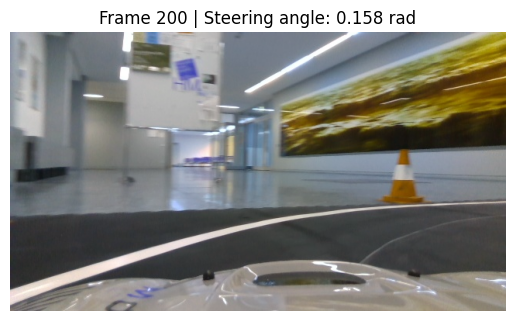

In [27]:
# At this point, the images and steering angles are synchronized
# Let's plot frame 200 alongside its corresponding steering angle

frame_idx = 200
plt.title(f"Frame {frame_idx} | Steering angle: {true_angles[frame_idx]:.3f} rad")
plt.imshow(images[frame_idx])
plt.axis("off")
plt.show()

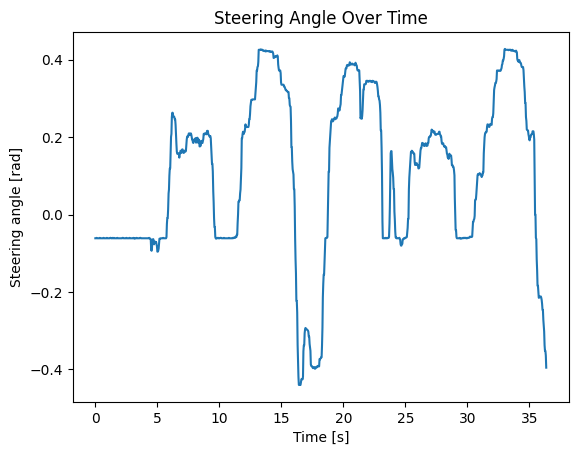

In [29]:
# Plot the synchronized steering angles over time

# Convert nanoseconds to seconds, relative to start
time_rel = (timestamps - timestamps[0])

plt.plot(time_rel, true_angles)
plt.xlabel("Time [s]")
plt.ylabel("Steering angle [rad]")
plt.title("Steering Angle Over Time")
plt.show()

In [ ]:
# Export all camera images from the bagfile into the 'export' directory
export_dir = project_dir / 'export'
r.export_images('/camera/color/image_jpeg', export_dir)